In [1]:
import dataset

In [2]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
root_name = "/home/h6x/git_projects/ornl-gnn-experiment/model_1/going_modular/data"

In [4]:
dataset =dataset.OpioidDataset(root_name, test=False)

Processing...
Done!


In [5]:
# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

OpioidDataset()
------------
Number of graphs: 1
Number of features: 15
Number of classes: 2


In [6]:
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[95, 15], edge_index=[2, 480], y=[95])
Number of nodes: 95
Number of edges: 480
Average node degree: 5.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [7]:
# Print first element
print(f'Graph: {dataset[0]}')

Graph: Data(x=[95, 15], edge_index=[2, 480], y=[95])


In [8]:
print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([95, 15])
tensor([[0.3521, 0.1765, 0.1613,  ..., 0.0365, 0.0979, 0.0700],
        [0.3557, 0.2491, 0.2565,  ..., 0.0467, 0.1185, 0.0233],
        [0.3775, 0.4602, 0.3026,  ..., 0.0183, 0.0797, 0.2747],
        ...,
        [0.2087, 0.1557, 0.2120,  ..., 0.0406, 0.0364, 0.0162],
        [0.2722, 0.2526, 0.1628,  ..., 0.0325, 0.0615, 0.0251],
        [0.2759, 0.1661, 0.1198,  ..., 0.0264, 0.0706, 0.0449]])


In [9]:
from torch_geometric.utils import to_dense_adj

In [10]:
A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (95, 95)
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]


In [12]:
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([95])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [13]:
from torch_geometric.utils import to_networkx

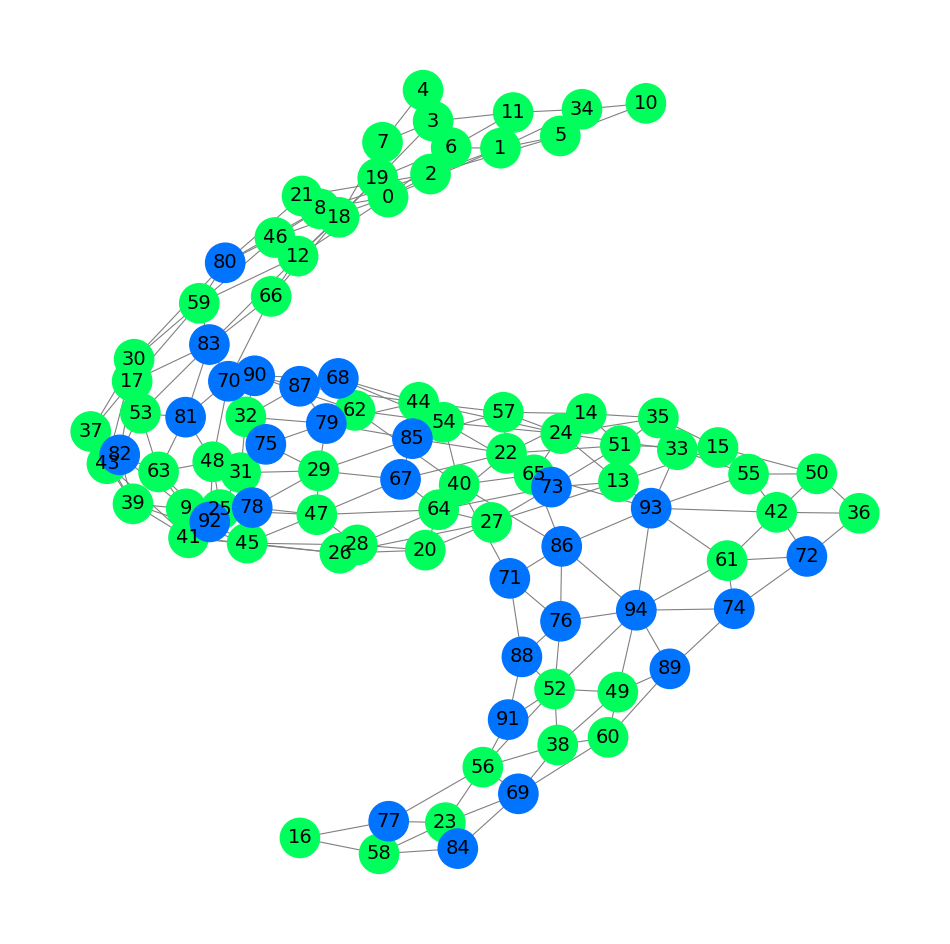

In [14]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

In [15]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [16]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z
model = GCN()
print(model)

GCN(
  (gcn): GCNConv(15, 3)
  (out): Linear(in_features=3, out_features=2, bias=True)
)


In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.012)

In [18]:
# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)
# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []
# Training loop
for epoch in range(1001):
    # Clear gradients
    optimizer.zero_grad()
    # Forward pass
    h, z = model(data.x, data.edge_index)
    # Calculate loss function
    loss = criterion(z, data.y)
    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)
    # Compute gradients
    loss.backward()
    # Tune parameters
    optimizer.step()
    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 0.76 | Acc: 29.47%
Epoch  10 | Loss: 0.67 | Acc: 70.53%
Epoch  20 | Loss: 0.61 | Acc: 70.53%
Epoch  30 | Loss: 0.61 | Acc: 70.53%
Epoch  40 | Loss: 0.60 | Acc: 70.53%
Epoch  50 | Loss: 0.60 | Acc: 70.53%
Epoch  60 | Loss: 0.60 | Acc: 70.53%
Epoch  70 | Loss: 0.60 | Acc: 70.53%
Epoch  80 | Loss: 0.60 | Acc: 70.53%
Epoch  90 | Loss: 0.60 | Acc: 70.53%
Epoch 100 | Loss: 0.60 | Acc: 70.53%
Epoch 110 | Loss: 0.59 | Acc: 70.53%
Epoch 120 | Loss: 0.59 | Acc: 70.53%
Epoch 130 | Loss: 0.59 | Acc: 70.53%
Epoch 140 | Loss: 0.58 | Acc: 70.53%
Epoch 150 | Loss: 0.57 | Acc: 70.53%
Epoch 160 | Loss: 0.57 | Acc: 70.53%
Epoch 170 | Loss: 0.56 | Acc: 70.53%
Epoch 180 | Loss: 0.55 | Acc: 70.53%
Epoch 190 | Loss: 0.55 | Acc: 70.53%
Epoch 200 | Loss: 0.54 | Acc: 71.58%
Epoch 210 | Loss: 0.53 | Acc: 70.53%
Epoch 220 | Loss: 0.53 | Acc: 70.53%
Epoch 230 | Loss: 0.52 | Acc: 71.58%
Epoch 240 | Loss: 0.51 | Acc: 72.63%
Epoch 250 | Loss: 0.51 | Acc: 73.68%
Epoch 260 | Loss: 0.50 | Acc: 73.68%
E

In [19]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

In [25]:
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

In [27]:
fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 1000, 10), interval=5000, repeat=True)

# Save the animation as a GIF
anim.save("animation.gif", writer='imagemagick', fps=30, bitrate=3000)

# Optionally, display the GIF in Jupyter Notebook
from IPython.display import Image
display(Image(filename="animation.gif"))

MovieWriter imagemagick unavailable; using Pillow instead.


In [ ]:
fig = plt.figure(figsize=(12, 12))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

In [22]:
# Print embeddings
print(f'Final embeddings = {h.shape}')
print(h)

Final embeddings = torch.Size([95, 3])
tensor([[0.0000, 1.4354, 0.0000],
        [0.0000, 2.0131, 0.0000],
        [0.0000, 1.2595, 0.0000],
        [0.0000, 2.4970, 0.0000],
        [0.0000, 2.0943, 0.0000],
        [0.0000, 1.5863, 0.0000],
        [0.0000, 1.5660, 0.0000],
        [0.0000, 1.9388, 0.0000],
        [0.0000, 0.8442, 0.0000],
        [0.0000, 0.3337, 0.0000],
        [0.0000, 0.7854, 0.0000],
        [0.0000, 1.4102, 0.0000],
        [0.0000, 0.5513, 0.0000],
        [0.0000, 0.4739, 0.0000],
        [0.0000, 0.6303, 0.0000],
        [0.0000, 0.7530, 0.0000],
        [0.0000, 0.3579, 0.0000],
        [0.0000, 0.3953, 0.0000],
        [0.0000, 0.4497, 0.0000],
        [0.0000, 0.9236, 0.0000],
        [0.0000, 0.5971, 0.0000],
        [0.0000, 0.6292, 0.0000],
        [0.0000, 0.4043, 0.0000],
        [0.0000, 0.0430, 0.0000],
        [0.0000, 0.7259, 0.0000],
        [0.0000, 0.2617, 0.0000],
        [0.0000, 0.7556, 0.0000],
        [0.0000, 0.4646, 0.0000],
        [

In [23]:
# Get first embedding at epoch = 0
embed = h.detach().cpu().numpy()

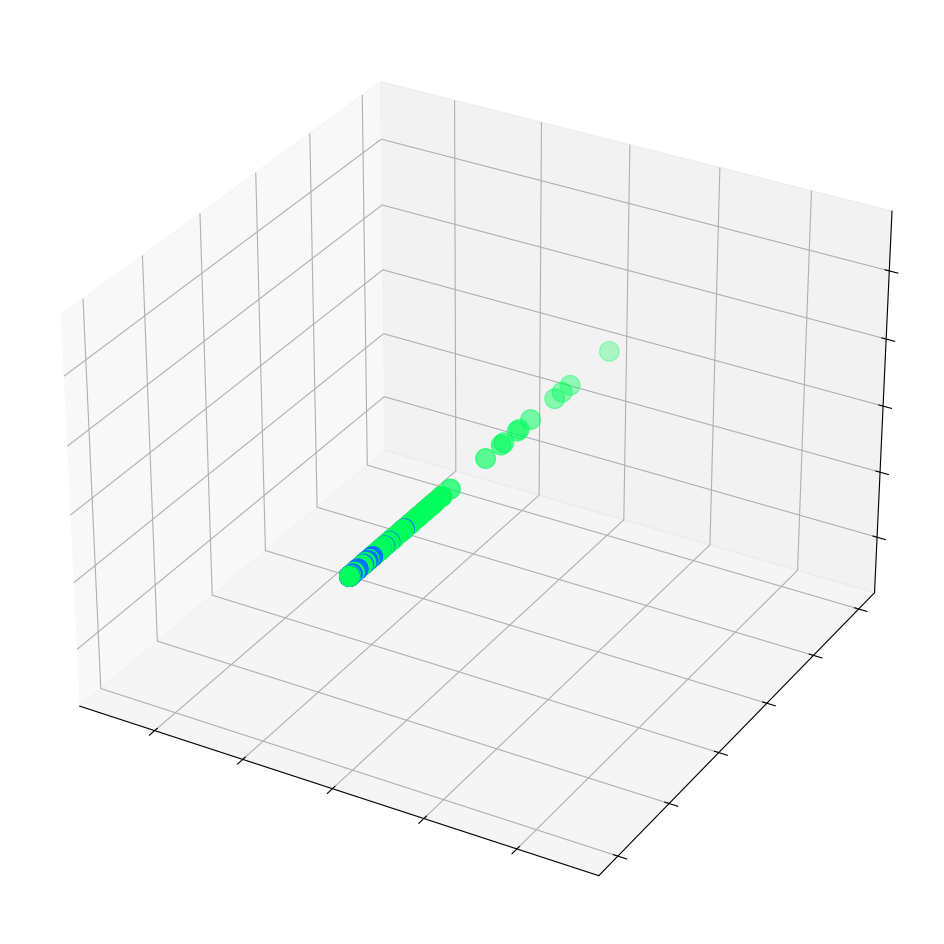

In [24]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
plt.show()